## Focal averaging implementation

Tomasz Szoldra, 2023

In [ ]:
!git clone https://github.com/tszoldra/attoDNN

In [ ]:
!pip install -e attoDNN

Implemented following formulas from  R Kopold et al 2002 J. Phys. B: At. Mol. Opt. Phys. 35 217 https://doi.org/10.1088/0953-4075/35/2/302

In [1]:
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from functools import partial, lru_cache
from scipy import stats, integrate, interpolate

In [2]:
cmap = mpl.cm.get_cmap('inferno')

In [ ]:
!wget --no-check-certificate https://chaos.if.uj.edu.pl/ZOA/tree//2303.13940/data_preprocessed/Qprop/QProp_Ar_small_sample.npz

In [3]:
path = 'QProp_Ar_small_sample.npz'

In [4]:
name = os.path.basename(path)

In [5]:
NPZ = np.load(path)

In [6]:
NPZ.files

['PDFs', 'labels', 'grid']

In [7]:
PDFs = NPZ['PDFs']
labels = NPZ['labels']
grid = NPZ['grid']

In [8]:
PDFs.shape 

(561, 468, 233)

In [9]:
labels.shape  # columns in labels: 'Up': 0, 'N': 1, 'CEP': 2

(561, 3)

In [10]:
feature_dict = {'Up': 0, 'N': 1, 'CEP': 2}  # defining it because different datasets, eg. SFA, have different features included

In [11]:
grid.shape

(468, 233, 2)

In [12]:
@lru_cache(maxsize=2048)
def weight_tight_focusing(I0, I):
    return 1. / I * integrate.quad( lambda zeta: (1. + zeta**2) * np.sqrt( np.log( I0 /  (I * (1. + zeta**2)) ) ), 0., np.sqrt( I0/I - 1. ))[0]

def weight_weak_focusing(I0, I):
    return 1. / I * np.sqrt( np.log( I0 / I ) )

def weight_tight_focusing_no_time_avg(I0, I):
    return 1. / I * np.sqrt( I0 / I - 1 ) * ( I0 / I + 2)

In [13]:
def focal_averaging(label, PDFs, labels, feature_dict, weight_fun=weight_tight_focusing):
    # label is the current label, PDFs and labels are over the whole dataset 
    # function assumes equal distances between Up datapoints
    
    Up_idx = feature_dict['Up']  # labels column with Up
    not_Up_idxs = np.where(np.arange(len(label)) != Up_idx)  # contains indexes of columns that are not Up but eg. CEP, N etc.
    
    Up0 = label[feature_dict['Up']]  # ponderomotive potential we are considering now. It is proportional to I.
    
    # if the lowest intensity in the dataset: nothing to average
    if Up0 == np.min(labels[:, Up_idx]):
        return PDFs
    
    not_Up_equal = lambda x: np.allclose(x[not_Up_idxs], label[not_Up_idxs])  # function that returns True if all other labels of the data entry except the Up have the same value
    
    
    Up_leq_Up0_idxs = np.where(np.logical_and(labels[:, Up_idx] <= Up0, 
                                              np.array([not_Up_equal(x) for x in labels])))  # data entries with lower intensities than Up0 and the same other labels
    
    Ups = labels[Up_leq_Up0_idxs][:, Up_idx]
    
    return np.einsum('i, ijk -> jk', np.array([weight_fun(Up0, x) for x in Ups]), PDFs[Up_leq_Up0_idxs])# result is not normalized

In [14]:
sample_idx = 50
label = labels[sample_idx]
label  # Up N CEP

array([ 0.27, 40.  ,  0.  ])

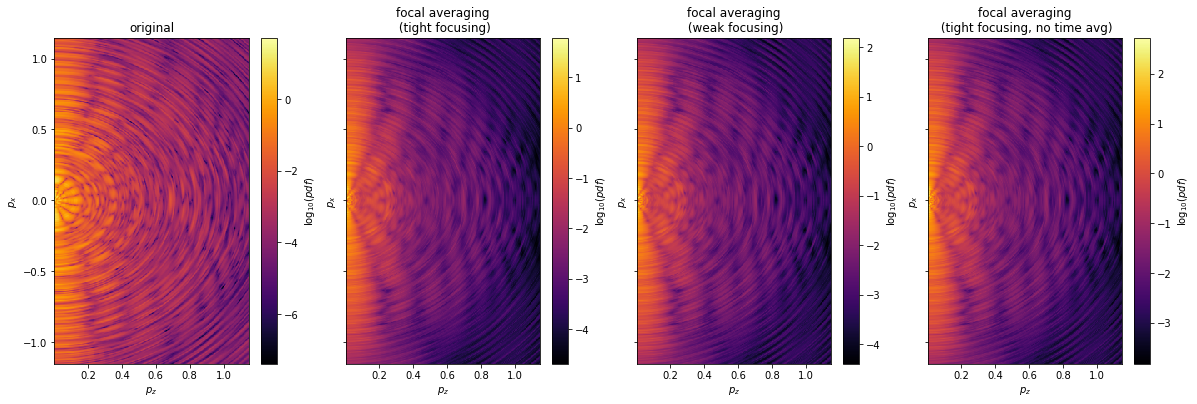

In [15]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20,6))

for ax in axs:
    ax.set_ylabel('$p_x$')
    ax.set_xlabel('$p_z$')

pcm0 = axs[0].pcolormesh(grid[:,:,1],grid[:,:,0],np.log10(PDFs[sample_idx]), cmap=cmap)
axs[0].set_title('original')

fig.colorbar(pcm0, ax=axs[0],label='$\\log_{10}(pdf)$')

axs[1].set_title('focal averaging\n (tight focusing)')
Z = np.log10(focal_averaging(label, PDFs, labels, feature_dict, weight_fun=weight_tight_focusing))
pcm1 = axs[1].pcolormesh(grid[:,:,1],grid[:,:,0],Z, cmap=cmap)
fig.colorbar(pcm1, ax=axs[1],label='$\\log_{10}(pdf)$')


axs[2].set_title('focal averaging\n (weak focusing)')
Z = np.log10(focal_averaging(label, PDFs, labels, feature_dict, weight_fun=weight_weak_focusing))
pcm2 = axs[2].pcolormesh(grid[:,:,1], grid[:,:,0], Z, cmap=cmap)
fig.colorbar(pcm2, ax=axs[2],label='$\\log_{10}(pdf)$')


axs[3].set_title('focal averaging\n (tight focusing, no time avg)')
Z = np.log10(focal_averaging(label, PDFs, labels, feature_dict, weight_fun=weight_tight_focusing_no_time_avg))
pcm2 = axs[3].pcolormesh(grid[:,:,1], grid[:,:,0], Z, cmap=cmap)
fig.colorbar(pcm2, ax=axs[3],label='$\\log_{10}(pdf)$')

plt.show()

In the paper we use the "tight focusing, no time average" variant.